<a href="https://colab.research.google.com/github/franktcao/builds/blob/master/yelp_what_is_funny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentimental Analysis with Yelp Open Dataset



##Introduction

Using [Yelp's open dataset](https://www.yelp.com/dataset) we want to get a handle on what makes a review funny. Intuitively, maybe it should be at an accessible 5th grade reading level to cast a wide net. Maybe it should be a useful or cool review. Should we expect lower stars or higher? 

We will classify the reviews as funny or unfunny using deep neural networks.

We will try to see if some sentiment analysis can be done via **convolutional layers**.




# Starting

## Setting things up

### Mounting Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Importing Useful Modules

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras


# Needed for Mac OSX
import os 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set the seed to reproduce results
from numpy.random import seed
seed(0xdeadbeef)
from tensorflow import set_random_seed
set_random_seed(0xdeadbeef)


Using TensorFlow backend.


Now, the file is pretty big so I've previously uploaded it to my Google drive. Let's mount it:

### Loading In Data

Use the h5py package to open our previously encoded numpy array. 

In [0]:
import h5py

# datadir = 'data/partitioned/tokenized/encoded/'
datadir = 'drive/My Drive/data/yelp_encoded/'
datafile = datadir + 'encoded_review_array.h5'

h5 = h5py.File(datafile,'r')
# help(h5py.File)
# h5.keys()

data = h5['reviews']

#### Examples

h5py only loads in the data needed to complete a given operation into memory. 

In [0]:
data.shape

(6685900, 254)

And looking at the first entry

At preprocessing stage, the first four slots of the entry are dedicated to: 

0. the number of stars; 
1. the number of "useful" upvotes;
2. the number of "funny" upvotes;
3. the number of "cool" upvotes;

respectively.

The remaining 250 integers are the encoded review text. 
* If the review contains more than 250 words, it's truncated/dropped. 
* If it contains less that 250 words the unused slots are encoded with zeros. 



In [0]:
data[0]

array([    1,     6,     1,     0,   805,   548,     5,   528,    28,
          65,   103,    55,   238,  8080,   264,    11,  4895,   537,
          62,    55, 10647,   182,  9013,   737,   753,  9013,    56,
          11,  3754,  2963,   276,     2,   977,  1865,    14,    24,
        1767,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

##  Looking at the Decoded Data

### Blackbox Decoding

To decode the encoded array, we need to use the class `Vocabulary` (from C. Bernet) which encoded the vocabulary. A vocabulary was built from the 5 GB review data and then used to encode it.

In [0]:
# # View Google's directory structure
# import pprint
# print('Module paths:')
# pprint.pprint(sys.path)
# print('\nCurrent working directory:',os.getcwd())

# from os import listdir
# from os.path import isfile, join
# files = [f for f in listdir('.') if isfile(join('.',f))]
# print(files)

In [0]:
import pickle 
import sys

# Load in the Vocabulary class
sys.path.append('/content/drive/My Drive/my_python_classes/yelp')
import vocabulary


# Load in the constructed Yelp vocabulary 
with open(datadir+'index.pck', 'rb') as pckf: 
    vocab = pickle.load(pckf)

# Method to decode review
def decode_review(encoded_review):
    encoded_review = encoded_review[encoded_review != 0] # Drop all padding
    return ' '.join( vocab.decode(encoded_review) )

### Example:

In [0]:
# Again, the encoded review is after the first 4 slots (for the scores)
first_review = data[0,4:]
# Drop padding
first_review = first_review[ first_review != 0 ]
print('Encoded review:\n\t', first_review[:14], '...')
decoded = decode_review(first_review)
print('Decoded review:\n\t', ' '.join( (decoded.split())[:14] ), '...' ) 

Encoded review:
	 [ 805  548    5  528   28   65  103   55  238 8080  264   11 4895  537] ...
Decoded review:
	 total bill this horrible service ? over $ these crooks actually had nerve charge ...


The `?` is not in our vocabulary ("stop words" are left out to like "the, he, she, it, ... etc" since they don't carry much information )

# Extracting Data
Let's extract the information needed to train our neural networks.  

###Features:

In [0]:
# Attributes
stars = data[:,0]
useful = data[:,1]
funny = data[:,2]
cool = data[:,3]

# All reviews
x = data[:, 4:]

### Extracting Readability

In [0]:
!pip install textatistic

  Stored in directory: /root/.cache/pip/wheels/1d/ec/34/69c3cae349149cd91552c4c470efcbd08bbd21ba30b12e08ab
  Stored in directory: /root/.cache/pip/wheels/85/46/93/46c556b5f054568b7470c86c4f76ea628a9a8bdf5a355b9c63
Successfully built textatistic pyhyphen


In [0]:
def get_readability_score_from_review(enc_review):
  review = decode_review(enc_review)
  return get_readability_score(review)

def get_readability_score(review):
  from textatistic import Textatistic
  
  # This helps define the end of a sentence, needed for flesch score
  review = review + '. . .' 
  #   print('\t',review,'\n')
  # Compute the readability scores 
  scores = Textatistic(review).scores
  #   return scores['flesch_score']
  return scores['gunningfog_score']


print(get_readability_score_from_review(x[2]))

7.6000000000000005


In [0]:
test = np.array(list(map(get_readability_score_from_review, x)))
# df['text'].apply(get_readability_score)

ZeroDivisionError: ignored

### Labels:
We want to know what makes a Yelp review funny, so we need to define what constitutes a funny review. So let's label what we decide is funny



In [0]:
# Since the majority of the reviews are not funny, 
# we will initialize the labels as not-funny (0)
y = np.zeros_like(funny)

# The funny reviews should have a least 1 funny upvote
y[funny>0] = 1

First, let's look at how the review frequency distribution of 'funny' upvotes of the first 1000 entries: 

(array([914.,  35.,  29.,   9.,   5.,   4.,   1.,   1.,   0.,   2.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <a list of 10 Patch objects>)

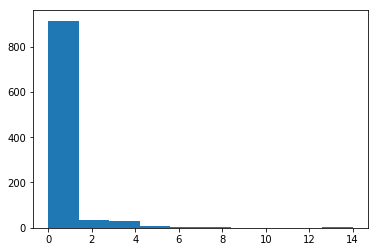

In [0]:
plt.hist(funny[:1000])

Since there are so many reviews without the 'funny' attribute, a good first step might be labeling reviews with at least 1 'funny' attribute as funny.

Let's define a few quick methods to read out an entry that we're interested in:

In [0]:
def print_entry(ientry):
    print()
    print('\tReview number:','{:,}'.format(ientry))
    print('\tStars:', stars[ientry])
    print('\tFunny votes:', funny[ientry])
    print('\tUseful votes:', useful[ientry])
    print('\tCool votes:', cool[ientry])
    print('\t\t',decode_review(get_entry_review(ientry)))
    print()
          
def get_entry_review(ientry):
    return x[ientry]


# Applying Machine Learning


## Convolutional Network

In natural language processing, we deal with a sentences, where it's not just a collection of independent words concatenated together. Rather, collection of words/subsets of the sentence bring out the semantics. 

The best way to visualize what a convultional network does is to consider a kernel size of 3. This is a window of 3 words long, where the idea is to extract the context from the sentence. Here is an illustrative example of what the convolutional layer sees when going through the review. The kernel or window moves by one word, and the kernel can be see as the boldface below: 

* **this movie is** really not good
* this **movie is really** not good
* this movie **is really not** good
* this movie is **really not good** 

Possibly the most "meaningful" sequence of words for a review would be **really not good** since it carries a lot of information. It will be easy for the network to understand the meaning of **not good** due to the convolution nature.

* a kernel size of 3,
* 64 filters. This means that 64 features (values) will be extracted from each position of the kernel,
* a ReLU activation. 


Splitting the dataset into a training and testing set can be done much nicer and random way but we can just do this manually to keep track of everything to reproduce results 

In [0]:
type(10**3)
type(10**3 * 10**3)

In [0]:
k = 10**3
M = k * k

In [0]:
# n_test = 20 * k
# n_train = 1 * M
# x_test = x[:n_test]
# y_test = y[:n_test]
# x_train = x[n_test:n_test+n_train]
# y_train = y[n_test:n_test+n_train]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x[:1020*k], y[:1020*k], 
                                                    test_size=20*k)#,
#                                                     random_state=0)

model = keras.Sequential()

model.add(keras.layers.Embedding(len(vocab.words), 64, input_length=250))
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_conv = model.fit(x_train, y_train,
                         epochs=4,
                         batch_size=1000,
                         validation_data=(x_test, y_test),
                         verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 250, 64)           1280128   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 248, 64)           12352     
_________________________________________________________________
flatten_9 (Flatten)          (None, 15872)             0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 15872)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                793650    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 51        
Total params: 2,086,181
Trainable params: 2,086,181
Non-trainable params: 0
_________________________________________________________________


In [0]:
help(history_conv.history)
history_conv.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

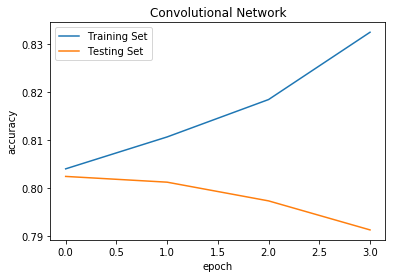

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
def plot_accuracy(history, title, miny=None):
    '''Plot the training and validation accuracy'''
    acc = history.history['acc']
    test_acc = history.history['val_acc']
    epochs = range(len(acc))
    plt.plot(epochs, acc)
    plt.plot(epochs, test_acc)
    if miny:
        plt.ylim(miny, 1.0)
    plt.title(title) 
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend( ['Training Set', 'Testing Set'] )
    plt.figure()
    
plot_accuracy(history_conv, 'Convolutional Network')

**Yikes**! That's quite a bit of overfitting. Let's see how we can fix that...

## Resampling
Let's train the dataset so that the data is about an equal split between those labeled 'funny' and those not

In [0]:
funny_ones = y > 0
unfunny_ones = y < 1


Maybe can take a quick peek to see which ones are funny and which aren't

In [0]:
def return_true_indices(tf_list):
    # Takes a true false list and returns the indices of the true
    # a = np.array([1, 2, 3, 1, 2, 3])
    # tf_list = a==2
    # returns [1, 4]
    itrues = np.arange(len(tf_list))
    return itrues[tf_list]  
def print_stats(sub, tot, typ):
  print('# of {}:'.format(typ),'{:,}'.format(len(sub)))
  print('# of total reviews:','{:,}'.format(len(tot)))
  print('% funny:','{:.2f}'.format(len(sub)/len(tot)*100), '%')
  print('\n\n\n')


In [0]:
# # print(funny_ones)
# ifunny_ones = return_true_indices(funny_ones)
# iunfunny_ones = return_true_indices(unfunny_ones)
# print('yfunny',len(y[funny_ones]))
# print('xunfunny',x[unfunny_ones].shape)
# print(len(y[funny_ones]) + len(y[unfunny_ones]))  

print("Funny Reviews")
print(ifunny_ones)
for f in ifunny_ones[-2:]:
    print_entry(f)

print_stats(ifunny_ones, y, 'funny')


print("Unfunny Reviews")
print(iunfunny_ones)
for u in iunfunny_ones[-2:]:
    print_entry(u)

# import locale
# locale.setlocale(locale.LC_ALL, 'en_US')
print_stats(iunfunny_ones, y, 'not funny')
# print('# of total reviews:',{len(y)}.format)
# print('# of total reviews:',f'{len(y):,}')
# print('% funny:',len(iunfunny_ones)/len(y)*100, '%')

Let's include half

In [0]:
n_funny = 500*k
n_unfunny = 1*M

y_new = (y[funny_ones])[:n_funny]
y_new = np.append( y_new, (y[unfunny_ones])[:n_unfunny] )
print(y_new)
print(y_new.shape)

x_new = (x[funny_ones])[:n_funny]
x_new = np.concatenate( [x_new, (x[unfunny_ones])[:n_unfunny]] )
print(x_new)
print(x_new.shape)

[1 1 1 ... 0 0 0]
(1500000,)
[[ 805  548    5 ...    0    0    0]
 [7425  419   11 ...    0    0    0]
 [   5   16   76 ...    0    0    0]
 ...
 [ 344   37    8 ...    0    0    0]
 [ 427  403   63 ...    0    0    0]
 [6042  640   14 ...    0    0    0]]
(1500000, 250)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 250, 64)           1280128   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 248, 64)           12352     
_________________________________________________________________
flatten_10 (Flatten)         (None, 15872)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15872)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 50)                793650    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 51        
Total params: 2,086,181
Trainable params: 2,086,181
Non-trainable params: 0
_________________________________________________________________


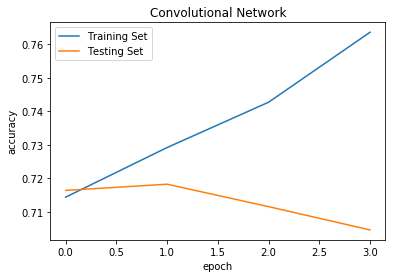

<Figure size 432x288 with 0 Axes>

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new 
                                                    ,test_size=20*k
                                                   #,random_state=0
                                                    )
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
x_train = x_train[:1*M]
y_train = y_train[:1*M]
print(x_train)
print(y_train.sum())


model = keras.Sequential()

model.add(keras.layers.Embedding(len(vocab.words), 64, input_length=250))
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_conv = model.fit(x_train, y_train,
                         epochs=4,
                         batch_size=1000,
                         validation_data=(x_test, y_test),
                         verbose=1)

plot_accuracy(history_conv, 'Convolutional Network')

Still some overfitting issues here. We are not getting to the root cause.

## Stacked Convolutional Layers 

In this section, we will optimize our convolutional network further by stacking convolutional layers. 

As we have done in [Tuning a deep convolutional network for image recognition](https://thedatafrog.com/deep-learning-keras/), we perform **max pooling** between each convolutional layer, and the layers extract more and more features as we progress in the network. 

To avoid overfitting, we use the whole dataset for training except for 20000 events that are kept for testing. 

W0716 00:39:01.860390 139665742980992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 64)           1280128   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 250, 16)           3088      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 125, 16)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 125, 32)           1568      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 62, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 62, 64)            6208      
_________________________________________________________________
flatten_4 (Flatten)          (None, 3968)              0         
__________

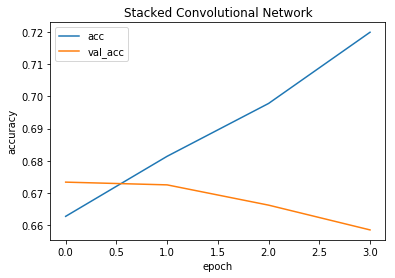

<Figure size 432x288 with 0 Axes>

In [0]:
# n_test = 20 * k
# x_test = x[:n_test]
# y_test = y[:n_test]
# x_train = x[n_test:n_test+n_train]
# y_train = y[n_test:n_test+n_train]

model = keras.Sequential()

model.add(keras.layers.Embedding(len(vocab.words), 64, input_length=250))
model.add(keras.layers.Conv1D(filters=16, kernel_size=3, 
                              padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=32, kernel_size=3, 
                              padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, 
                              padding='same', activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_conv_stacked = model.fit(x_train, y_train,
                    epochs=4,
                    batch_size=1000,
                    validation_data=(x_test, y_test),
                    verbose=1)

plot_accuracy(history_conv_stacked, 'Stacked Convolutional Network')

# Investigating the Misclassified Reviews

It's always interesting to look at misclassified examples to get a hint of what's going on and maybe get ideas for further improvements. That's what we're going to do now, with the first 100 examples. 

Here are the predictions and the true labels for these samples: 

In [0]:
x_sample = x_test
y_sample = y_test
preds = model.predict_classes(x_sample)
preds = np.array(preds).flatten()
print('true:')
print(y_sample)
print('predictions:')
print(preds)

true:
[0 1 1 ... 0 1 0]
predictions:
[0 1 1 ... 1 1 0]


Now, we select the misclassified examples, together with the true label and the prediction for these examples:

In [0]:
idx = preds!=y_sample
miscl = x_sample[idx]
miscl_pred = preds[idx]
miscl_true = y_sample[idx]

print('true:')
print(miscl_pred)
print('predictions:')
print(miscl_true)
print(miscl_true.shape)

true:
[1 0 1 ... 1 1 1]
predictions:
[0 1 0 ... 0 0 0]
(1280,)


In [0]:
data[:1]

array([[    1,     6,     1,     0,   805,   548,     5,   528,    28,
           65,   103,    55,   238,  8080,   264,    11,  4895,   537,
           62,    55, 10647,   182,  9013,   737,   753,  9013,    56,
           11,  3754,  2963,   276,     2,   977,  1865,    14,    24,
         1767,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

And we print the first five: 

In [0]:
for pred, true, rev in zip(miscl_pred[:5], miscl_true, miscl[:5]):
    rev = rev[rev!=0] # remove padding
    print(pred, true)
    print(' '.join(vocab.decode(rev)))
    print('\n')

1 0
tracy dessert had big name hong kong one first markham place has been here many years now ! came some chinese dessert must say their selection has increased tremendously over years might as well add price has also increased tremendously as well waitress gave us tea which could taste had red date fancy ! simple taro with coconut with tapioca pearls like $ 5.25 or something basically all desserts were more than $ 5 's crazy ! can literally just make this dessert at home bowl would probably cost like $ 0.50 few years ago think can still get like $ 3- $ 4 which more reasonable but wow more than $ 5 little over top this dessert though must say tracy dessert they little more on expensive side also saw other items on menu like fish balls chicken wings shaved ice friend got mango drink with fresh mango ! 'm also surprised how many people come tracy dessert after work came on sunday tables were always filled think amount tables they had were just perfect because no one really waited seats l

In [0]:
df = pd.DataFrame(data=data[:100,:4], columns=['stars','useful','funny','cool'])
df['misc'] = idx[:100]
# print the misclassified lines: 
df[df['misc']==False]

,stars,useful,funny,cool,misc
0,1,6,1,0,False
1,5,0,0,0,False
2,5,3,0,0,False
3,5,0,0,0,False
4,1,7,0,0,False
5,4,0,0,0,False
7,1,3,1,1,False
8,2,1,0,0,False
9,3,1,0,1,False
10,4,0,0,0,False
